In [90]:
from networks.mpnet import MPNet
import torch
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sst_envs.utils import load_data, visualize_point

In [92]:
# setup = "default"
setup = "nodiff_noaug_20step2e-2"

# setup = "default_norm_aug"
# setup = "norm_nodiff_noaug_20step2e-2"
# setup = "norm_nodiff_noaug_5step2e-2"
# setup = "norm_nodiff_noaug_20step2e-3"
mpnet = MPNet(ae_input_size=32, ae_output_size=64, in_channels=1, state_size=4)

model = "acrobot_obs"
env = 1
traj_id = 0
goal_radius = 5


mpnet.load_state_dict(torch.load('output/acrobot_obs/{}/ep150'.format(setup)))
# mpnet.eval()
mpnet.train()

def plan(start_th, goal_th, env_vox, mpnet):
    start_goal = torch.cat((start_th.float(), goal_th.float()), dim=1)
    with torch.no_grad():
        sample = mpnet(start_goal, env_vox)         
    return sample.clone()
def visualize(path, start, goal, ax, color='skyblue'):
    path = np.array(path)
    ax.scatter(start[0], start[1], color='orange')
    ax.scatter(goal[0], goal[1], color='red')
    ax.plot(path[:, 0], path[:, 1], color=color)
    ax.scatter(path[:, 0], path[:, 1], color='blue', s=3)
    ax.scatter(path[-1, 0], path[-1, 1], color='orange')

    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)

def distance(point1, point2):
    LENGTH = 20.
    x = np.cos(point1[0] - np.pi / 2)+np.cos(point1[0] + point1[1] - np.pi / 2)
    y = np.sin(point1[0] - np.pi / 2)+np.sin(point1[0] + point1[1] - np.pi / 2)
    x2 = np.cos(point2[0] - np.pi / 2)+np.cos(point2[0] + point2[1] - np.pi / 2)
    y2 = np.sin(point2[0] - np.pi / 2)+np.sin(point2[0] + point2[1] - np.pi / 2)
    return LENGTH*np.sqrt((x-x2)**2+(y-y2)**2)
env_vox_all = torch.from_numpy(np.load('sst_envs/{}_env_vox.npy'.format(model))).float()
env_vox = env_vox_all[env].float().unsqueeze(0)
ref_path_dict = load_data(model, env, traj_id)
ref_path = ref_path_dict['path']
ref_sg = ref_path_dict['start_goal']

0 tensor(60.6857) tensor([ 0.,  0.,  0.,  0.])
1 tensor(60.4387) tensor([ 0.0253,  0.2592, -0.0820,  0.7674])
2 tensor(57.4419) tensor([-0.5570,  0.7419, -0.7627,  2.0575])
3 tensor(57.2514) tensor([-0.2235,  0.8418,  0.4843,  0.3883])
4 tensor(57.8397) tensor([ 0.0754,  0.6877,  0.4181, -0.1894])
5 tensor(45.3973) tensor([ 0.6158,  1.2555, -1.6890,  1.5545])
6 tensor(30.3852) tensor([ 0.4511,  2.1498, -3.5057,  3.3455])
7 tensor(22.8809) tensor([-1.1146, -1.7718, -3.5017,  3.2962])
8 tensor(18.5275) tensor([-1.4669, -1.6295, -0.8442,  1.1794])
9 tensor(18.5305) tensor([-1.1528, -1.9627,  1.6944, -1.2146])
10 tensor(42.9821) tensor([-0.0251, -1.6249,  3.6908, -3.5621])
11 tensor(32.3542) tensor([ 1.2058,  1.4380,  2.9708, -3.5417])
12 tensor(49.5955) tensor([ 1.3637,  0.1234,  0.4731, -0.8346])
13 tensor(60.3630) tensor([-0.1651,  0.1089, -2.0843,  3.4735])
14 tensor(53.4898) tensor([-0.3715,  1.2190, -1.3379,  3.3503])
15 tensor(52.6788) tensor([-0.4896,  1.2949, -0.6566,  2.5743])
16

<IPython.core.display.Javascript object>


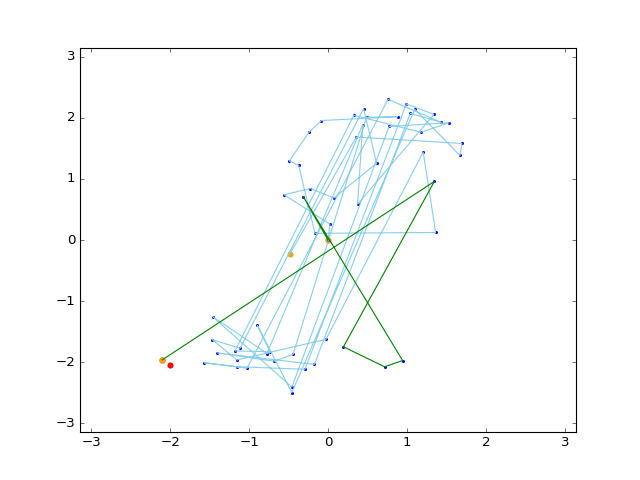

In [93]:
path = []
start = ref_path[0].copy()
# goal = ref_path[-1].copy()
goal = ref_sg[-1].copy()
start_th = torch.from_numpy(start).unsqueeze(0).float()
goal_th = torch.from_numpy(goal).unsqueeze(0).float()

endeff = [[0, -40]]
node1 = [[0, -20]]
path.append(start_th[0].numpy())
for i in range(50):
    dis = distance(start_th[0], goal_th[0])
    print(i,dis, start_th[0])
    if dis < goal_radius:    
        break
    sample = plan(start_th, goal_th, env_vox, mpnet)
    start_th = sample[:, :4].clone()
    if start_th[:, 0] > 1*np.pi:
        start_th[:, 0] -= 2*np.pi
    if start_th[:, 0] < -1*np.pi:
        start_th[:, 0] += 2*np.pi
        
    if start_th[:, 1] > 1*np.pi:
        start_th[:, 1] -= 2*np.pi
    if start_th[:, 1] < -1*np.pi:
        start_th[:, 1] += 2*np.pi
        
    if start_th[:, 2] > 1*6:
        start_th[:, 2] = 1*6
    if start_th[:, 2] < -1*6:
        start_th[:, 2] = -1*6
    
    if start_th[:, 3] > 1*6:
        start_th[:, 3] = 1*6
    if start_th[:, 3] < -1*6:
        start_th[:, 3] = -1*6
    
    ex1, ey1, ex2, ey2 = visualize_point(start_th.clone()[0])
    endeff.append([ex2, ey2])
    node1.append([ex1, ey1])
    path.append(start_th[0].numpy().copy())
print(i)
%matplotlib notebook
fig1, ax1 = plt.subplots()


path_from_data = ref_path.copy()
# path_from_data[:, :2] /= np.pi
# path_from_data[:, 2:] /= 6
# #path_from_data = data[0:150, 1:]
visualize(path, start, goal, ax1)

visualize(path_from_data, path_from_data[0], path_from_data[-1], ax1, color='green')

# path = np.array(path)[:, :4]
# path[:, :2] *= np.pi
# path[:, 2:] *= 6
# np.save('mpnet_path.npy', path)

<IPython.core.display.Javascript object>


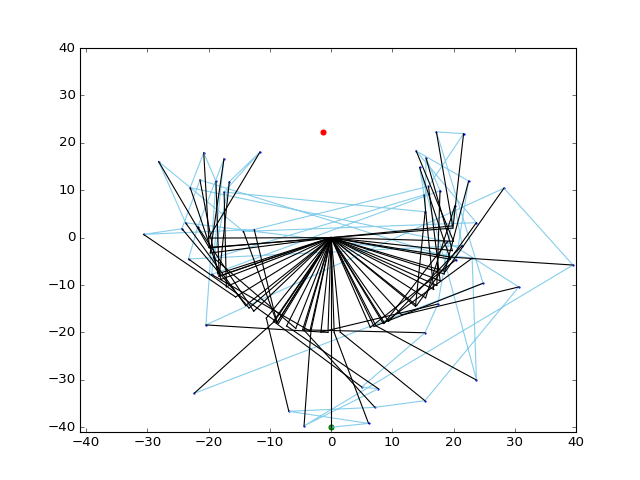

(-41, 40)

In [94]:
%matplotlib notebook
endeff = np.array(endeff)
node1 = np.array(node1)
x1, y1, x2, y2 = visualize_point(ref_path[-1])
plt.plot(endeff[:,0], endeff[:,1], color='skyblue')
plt.scatter(endeff[:,0], endeff[:,1], color='blue', s=1)

for i in range(endeff.shape[0]):
    plt.plot([0, node1[i,0]], [0, node1[i,1]], color='black')
    plt.plot([node1[i,0], endeff[i,0]], [node1[i,1], endeff[i,1]], color='black')

plt.scatter(endeff[0, 0], endeff[0, 1], color='green')
plt.scatter(x2, y2, color='red')
plt.xlim(-41, 40)
plt.ylim(-41, 40)


In [ ]:
# fig2, ax2 = plt.subplots()
# visualize(ref_path, ref_path[0], ref_path[-1], ax2)

In [65]:
data = np.load("sst_envs/{}/acrobot_obs_path_data.npy".format(setup))
gt = np.load("sst_envs/{}/acrobot_obs_gt.npy".format(setup))
data[0],gt[0]

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        2.50724579, 1.50927706, 0.        , 0.        ]),
 array([ 0.24618453, -0.5358435 ,  1.08646313, -2.47822479]))

In [66]:
data[0:18, 1:4+1]


array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.24618453, -0.5358435 ,  1.08646313, -2.47822479],
       [ 0.29992168, -0.85714599, -0.89048188,  1.02415431],
       [ 0.024715  , -0.46927478, -1.58452605,  2.52628692],
       [-0.73631024,  1.01071844, -1.40851439,  3.55385285],
       [-0.89120884,  1.50734784, -0.36267027,  2.50518148],
       [-0.22548611,  1.20705531,  3.43265889, -4.29835481],
       [ 1.31151125, -1.02779731,  2.99462068, -4.80725552],
       [ 1.82169607, -2.3571862 , -0.70108983, -1.98354599],
       [ 1.05585886, -2.64572119, -3.89214283,  0.58986767],
       [-0.71286184, -1.82562983, -3.69050896,  2.79329154],
       [-1.191028  , -1.44055217, -2.0169284 ,  1.68025333],
       [-1.38639485, -1.25818887, -1.07401745,  1.24162405],
       [-0.85304678, -1.87666425,  3.80542379, -3.87222229],
       [ 1.1221288 ,  2.84536764,  4.68318722, -3.40687821],
       [ 1.62689883,  2.45531076,  3.54976229, -3.01216104],
       [ 2.43081915,  1.

<IPython.core.display.Javascript object>


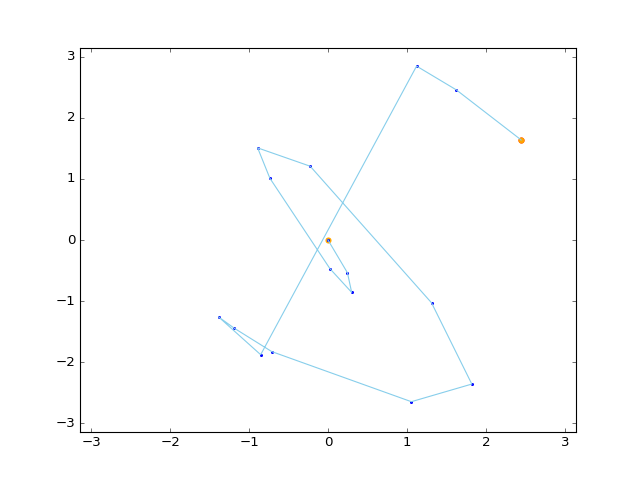

In [67]:
fig2, ax2 = plt.subplots()
p = data[0:18, 1:4+1]
visualize(p, p[0], p[-1], ax2)

In [86]:
# fig2, ax2 = plt.subplots()
# p = data[29:59, 1:4+1]
# visualize(p, p[0], p[-1], ax2)


tensor(1.2994)
tensor(1.0311)
tensor(0.3518)


<IPython.core.display.Javascript object>


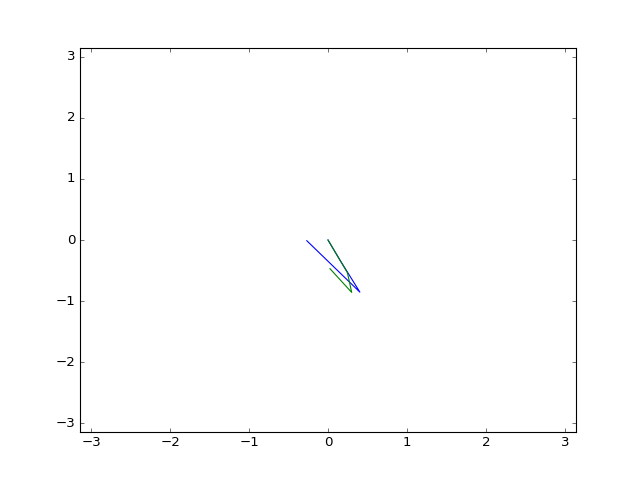

(-3.141592653589793, 3.141592653589793)

In [88]:
%matplotlib notebook
mpnet.eval()
output = [np.array([0,0,0,0])]
gt_list = [np.array([0,0,0,0])]
for i in range(3):
    start_goal_th = torch.from_numpy(data[i:i+1,1:]).float()
    gt_th = torch.from_numpy(gt[i:i+1,:]).float()
    gt_list.append(gt[i,:])
    with torch.no_grad():
        sample = mpnet(start_goal_th, env_vox) 
    output.append(sample[0].numpy())
    print(torch.nn.functional.mse_loss(sample, gt_th))
output = np.array(output)
gt_list = np.array(gt_list)
plt.plot(output[:, 0], output[:, 1], color='blue')
plt.plot(gt_list[:, 0],gt_list[:, 1], color='green')
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)


In [55]:
output, gt_list

(array([[ 0.37440842, -0.63912064,  0.23658663, -1.0385357 ],
        [ 0.3443067 , -1.1333375 , -0.17511106, -0.86472887],
        [-0.288009  , -0.36696804, -2.8477302 ,  4.6803412 ]],
       dtype=float32),
 array([[ 0.24618453, -0.5358435 ,  1.08646313, -2.47822479],
        [ 0.29992168, -0.85714599, -0.89048188,  1.02415431],
        [ 0.024715  , -0.46927478, -1.58452605,  2.52628692]]))

In [57]:
data[0:1,1:]

array([[0.        , 0.        , 0.        , 0.        , 2.50724579,
        1.50927706, 0.        , 0.        ]])

In [76]:
sample

tensor([[ 0.1927, -0.3922,  0.1503, -0.6629]])

In [81]:
torch.sum((sample-gt_th)**2)/4

tensor(1.0488)